In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import gc


from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

sys.path.append('../dataset_construction')
sys.path.append('../../util')
from pano_utils import *
import panoseti_file_interfaces as pfi

In [16]:
def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df

In [178]:
data_dir = '/Users/nico/Downloads/panoseti_test_data/obs_data/data'
# run_dir = 'obs_Lick.start_2023-08-01T05:14:21Z.runtype_sci-obs.pffd'
run_dir = 'obs_Lick.start_2023-08-29T04:49:58Z.runtype_sci-obs.pffd'

ori = pfi.ObservingRunInterface(data_dir, run_dir)

In [18]:
ori.obs_pff_files

{254: {'img': [],
  'ph': [{'fname': 'start_2023-08-29T04_50_46Z.dp_ph256.bpp_2.module_254.seqno_0.pff',
    'seqno': 0,
    'nframes': 12659,
    'first_unix_t': 1693284653.7706468,
    'last_unix_t': 1693295935.3568306}],
  'img_supermedian': None,
  'img_spatial_median_df': None},
 1: {'img': [{'fname': 'start_2023-08-29T04_50_49Z.dp_img16.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 1574804,
    'first_unix_t': 1693284655.2144074,
    'last_unix_t': 1693284812.6947074},
   {'fname': 'start_2023-08-29T04_53_33Z.dp_img16.bpp_2.module_1.seqno_1.pff',
    'seqno': 1,
    'nframes': 1574804,
    'first_unix_t': 1693284812.6948075,
    'last_unix_t': 1693284970.1751075}],
  'ph': [{'fname': 'start_2023-08-29T04_50_49Z.dp_ph256.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 10519,
    'first_unix_t': 1693284655.602064,
    'last_unix_t': 1693295937.1693113}],
  'img_supermedian': None,
  'img_spatial_median_df': None},
 3: {'img': [],
  'ph': [{'fname': 'start_

In [19]:
def plot_img(data, cbar=False, ax=None, vmin=-50, vmax=50, cmap='rocket'):
    div = 1 / np.sqrt(abs(data))
    div = np.nan_to_num(div, nan=1)
    
    if ax:
        im_orig = ax.imshow(
            data * div, vmin=vmin, vmax=vmax, cmap=cmap,
        )
    else:
        im_orig = plt.imshow(
            data *  div, vmin=vmin, vmax=vmax, cmap=cmap#cmap='crest_r',
        )
    if cbar:
        cbar_orig = plt.colorbar(im_orig, label='Counts', fraction=0.046, location='right')
    plt.axis('off')

In [20]:
def plot_grid(imgs, title, cols=10, rows_per_plot=10, vmin=-100, vmax=100, cmap='rocket'):
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    title_added = False
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                plot_img(img, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
                if not title_added:
                    ax.set_title(title)
                    title_added = True
        plt.show()
        plt.close()

In [21]:
?ori.stack_frames

Signature:
ori.stack_frames(
    start_file_idx,
    start_frame_offset,
    module_id,
    stacked_integration_usec=12000,
    agg='mean',
    allow_partial_image=False,
)
Docstring:
Stacks consecutive imaging frames until the cumulative imaging time equals stacked_integration_usec.
    1) Evenly samples image frames between the start frame, specified by start_file_idx and start_frame_offset, and
    the frame with timestamp now - stacked_integration_ussec.
    2) Then aggregates the frames according to the agg procedure ['sum', 'mean'].

By default, stack until a total of 6ms of observational data is accumulated. e.g.:
- For a 100us integration time, add 60 images together.
- For a 2000us integration time, add 3 images together.

@param start_file_idx: sequence number of PFF imaging file in which frame sampling should begin.
@param start_frame_offset: frame offset within the specified file, relative to the earliest frame in this file.
@param stacked_integration_usec: total duration o

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Density'>

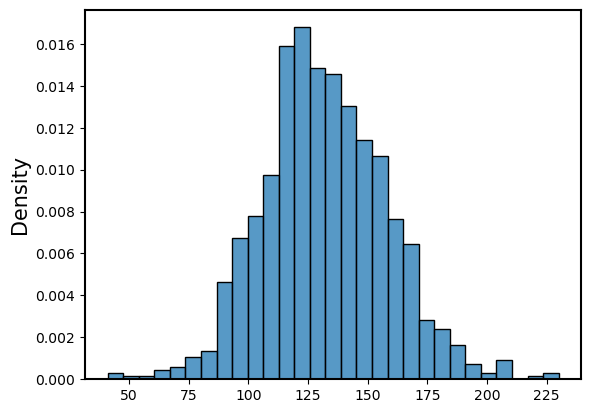

In [22]:
img, stacked_meta = ori.stack_frames(0, 0, 1, stacked_integration_usec=12e3, agg='mean')
# plot_img(img, vmin=10, vmax=15, cmap='rocket')
sns.histplot(
    img.ravel(),
    stat='density',
    label='pixel_stats',
)

In [24]:
# np.random.seed(50)
# module_id = 1
# for k in [10]:
#     spatial_medians, buffer, buffer_no_spatial_medians, supermedian, flat, spdf = ori.compute_imaging_baselines(
#         module_id, spatial_median_window_usec=k*10**6, max_samples_per_window = 10
#     )
#     sm_idxs = np.linspace(0, len(spatial_medians) - 1, 50).astype(int)
#     bf_idxs = np.linspace(0, len(buffer) - 1, 50).astype(int)
#     bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 50).astype(int)
#     flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
#     print('done')
    # plot_grid(spatial_medians[sm_idxs, :, :], f'(spatial medians) window_length = {k} s', vmin=10, vmax=15)
    # # plot_grid(buffer[bf_idxs, :, :], f'(original) window_length = {k} s', vmin=10, vmax=15)
    # plot_grid(buffer_no_spatial_medians[bfnsm_idxs, :, :], f'orig - (spatial median): window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')
    # plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

done


In [192]:
data_dir = '/Users/nico/Downloads/panoseti_test_data/obs_data/data'
run_dir = 'obs_Lick.start_2023-08-01T05:14:21Z.runtype_sci-obs.pffd'
# run_dir = 'obs_Lick.start_2023-08-29T04:49:58Z.runtype_sci-obs.pffd'


# Compute spatial median baselines
ori = pfi.ObservingRunInterface(data_dir, run_dir, do_baseline_subtraction=True)

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_88556/2438112594.py:2: RuntimeWarning:

divide by zero encountered in divide



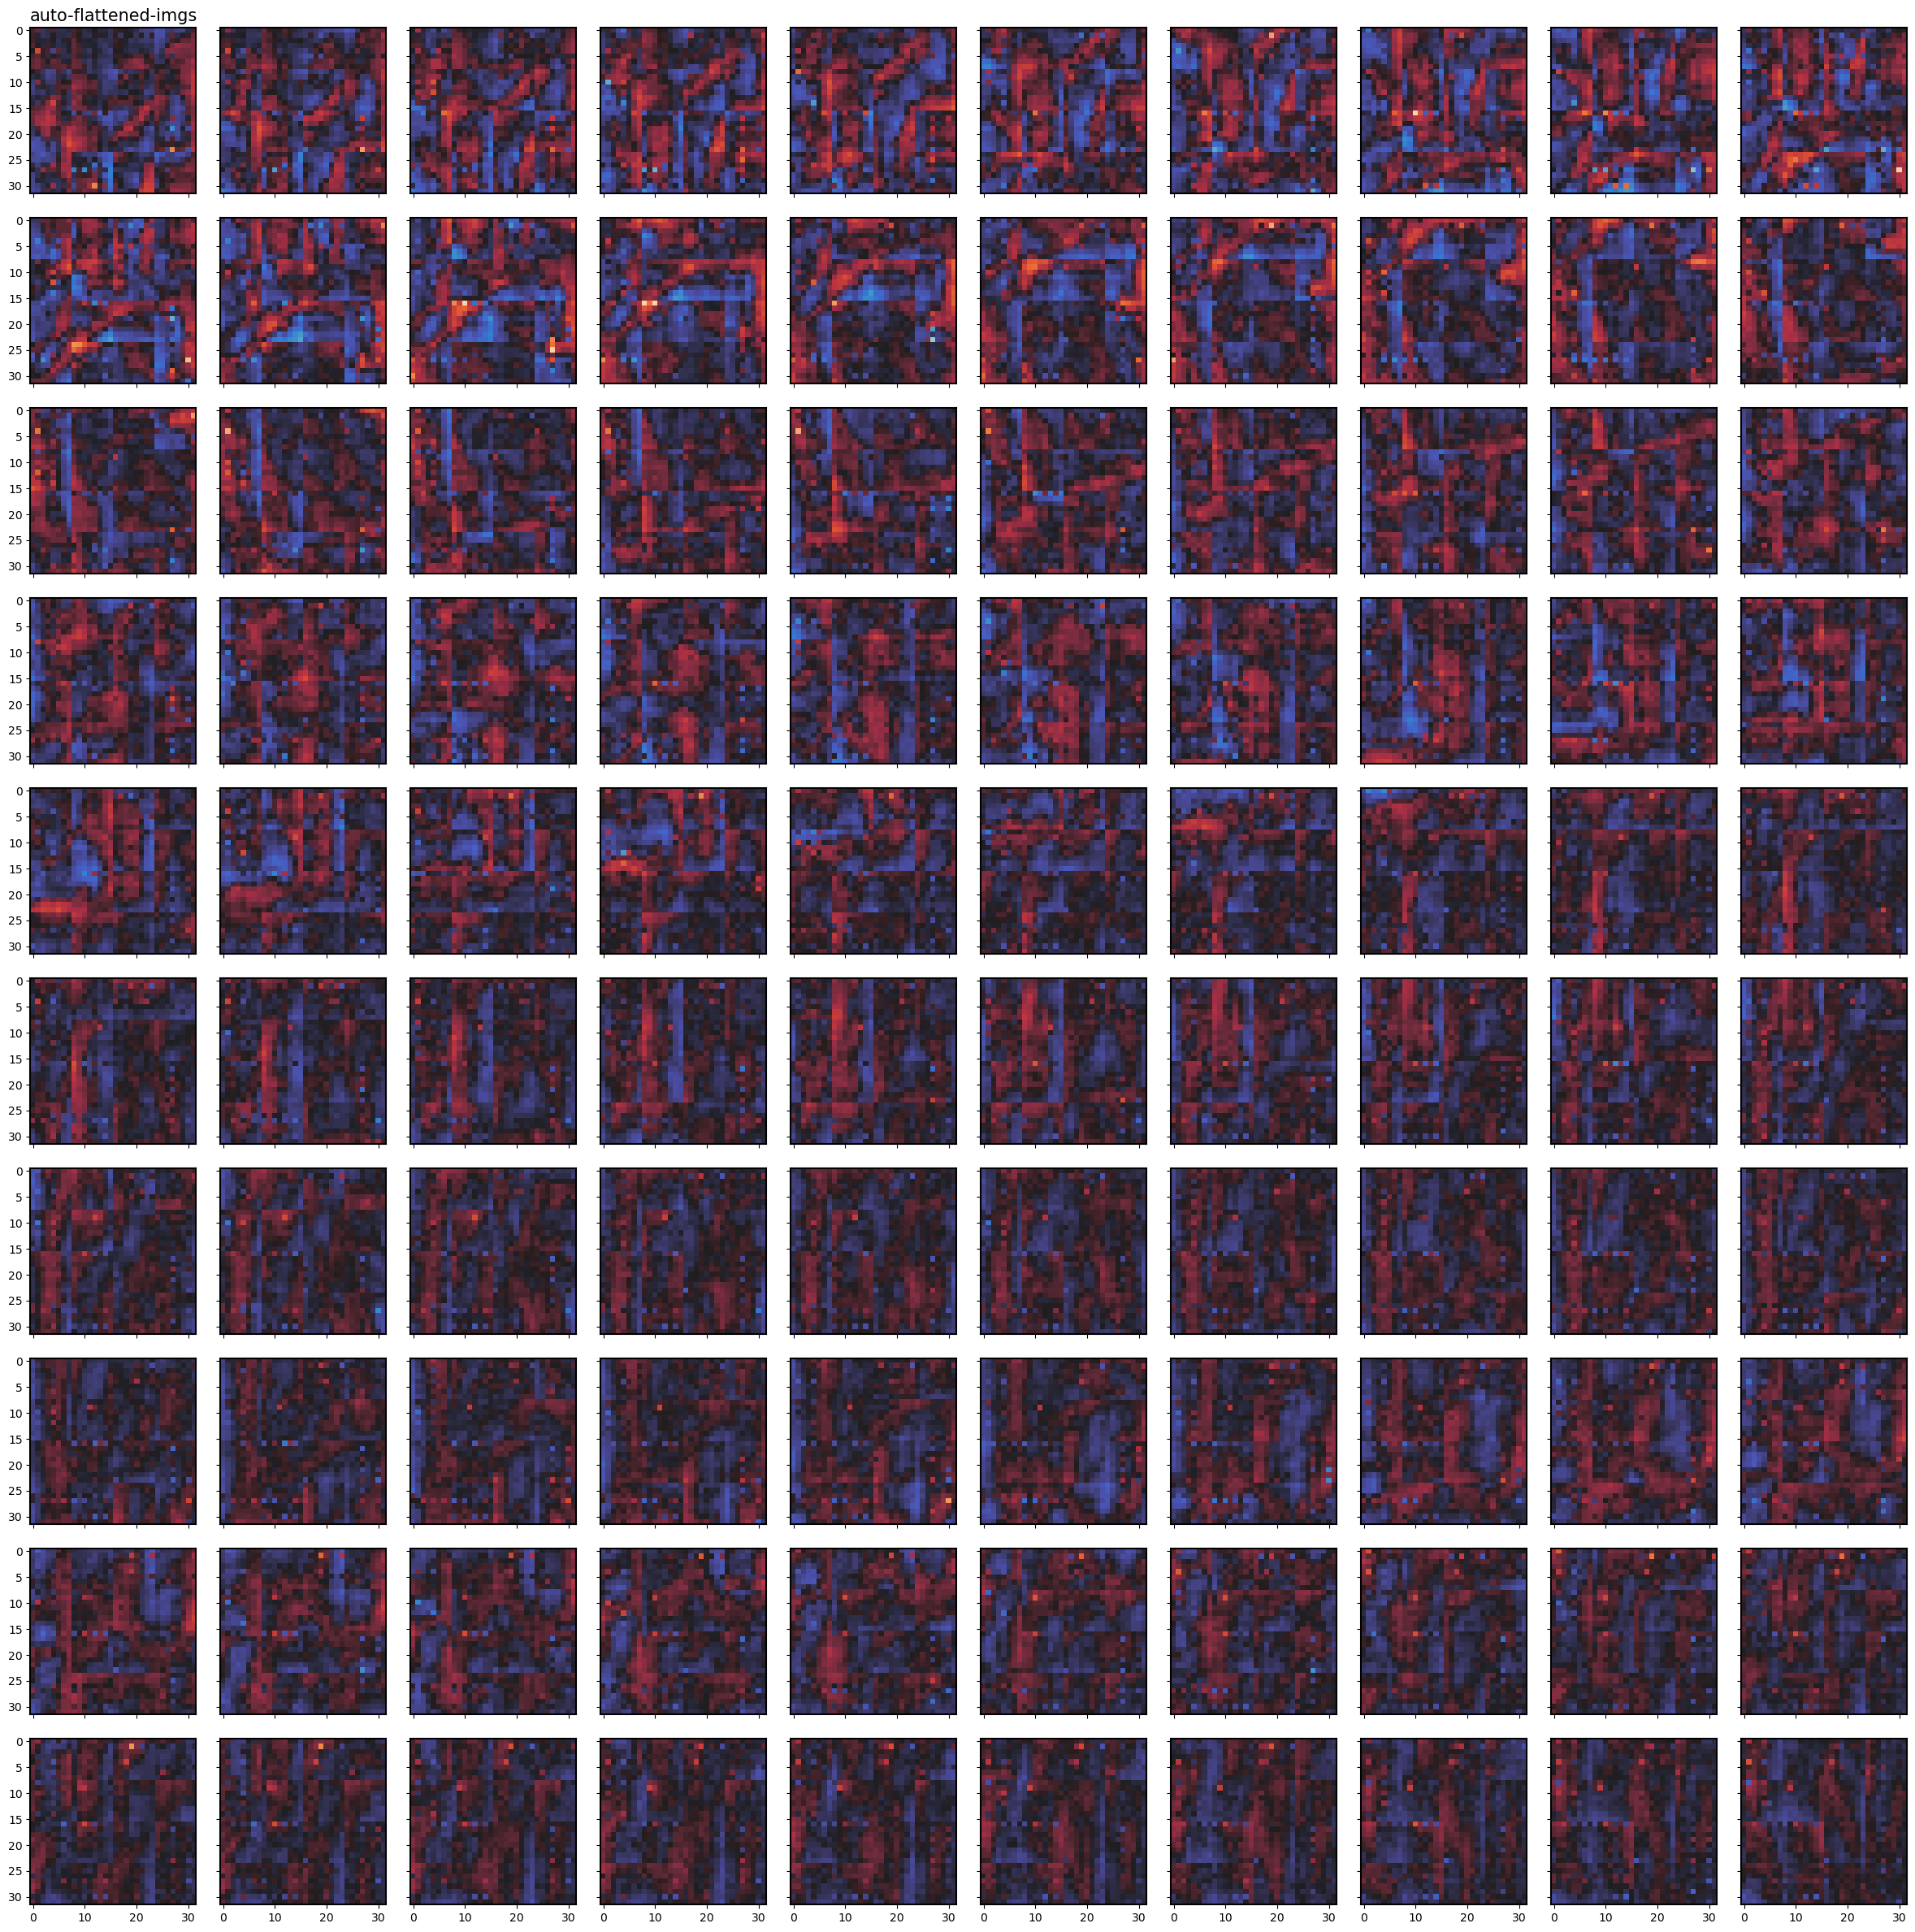

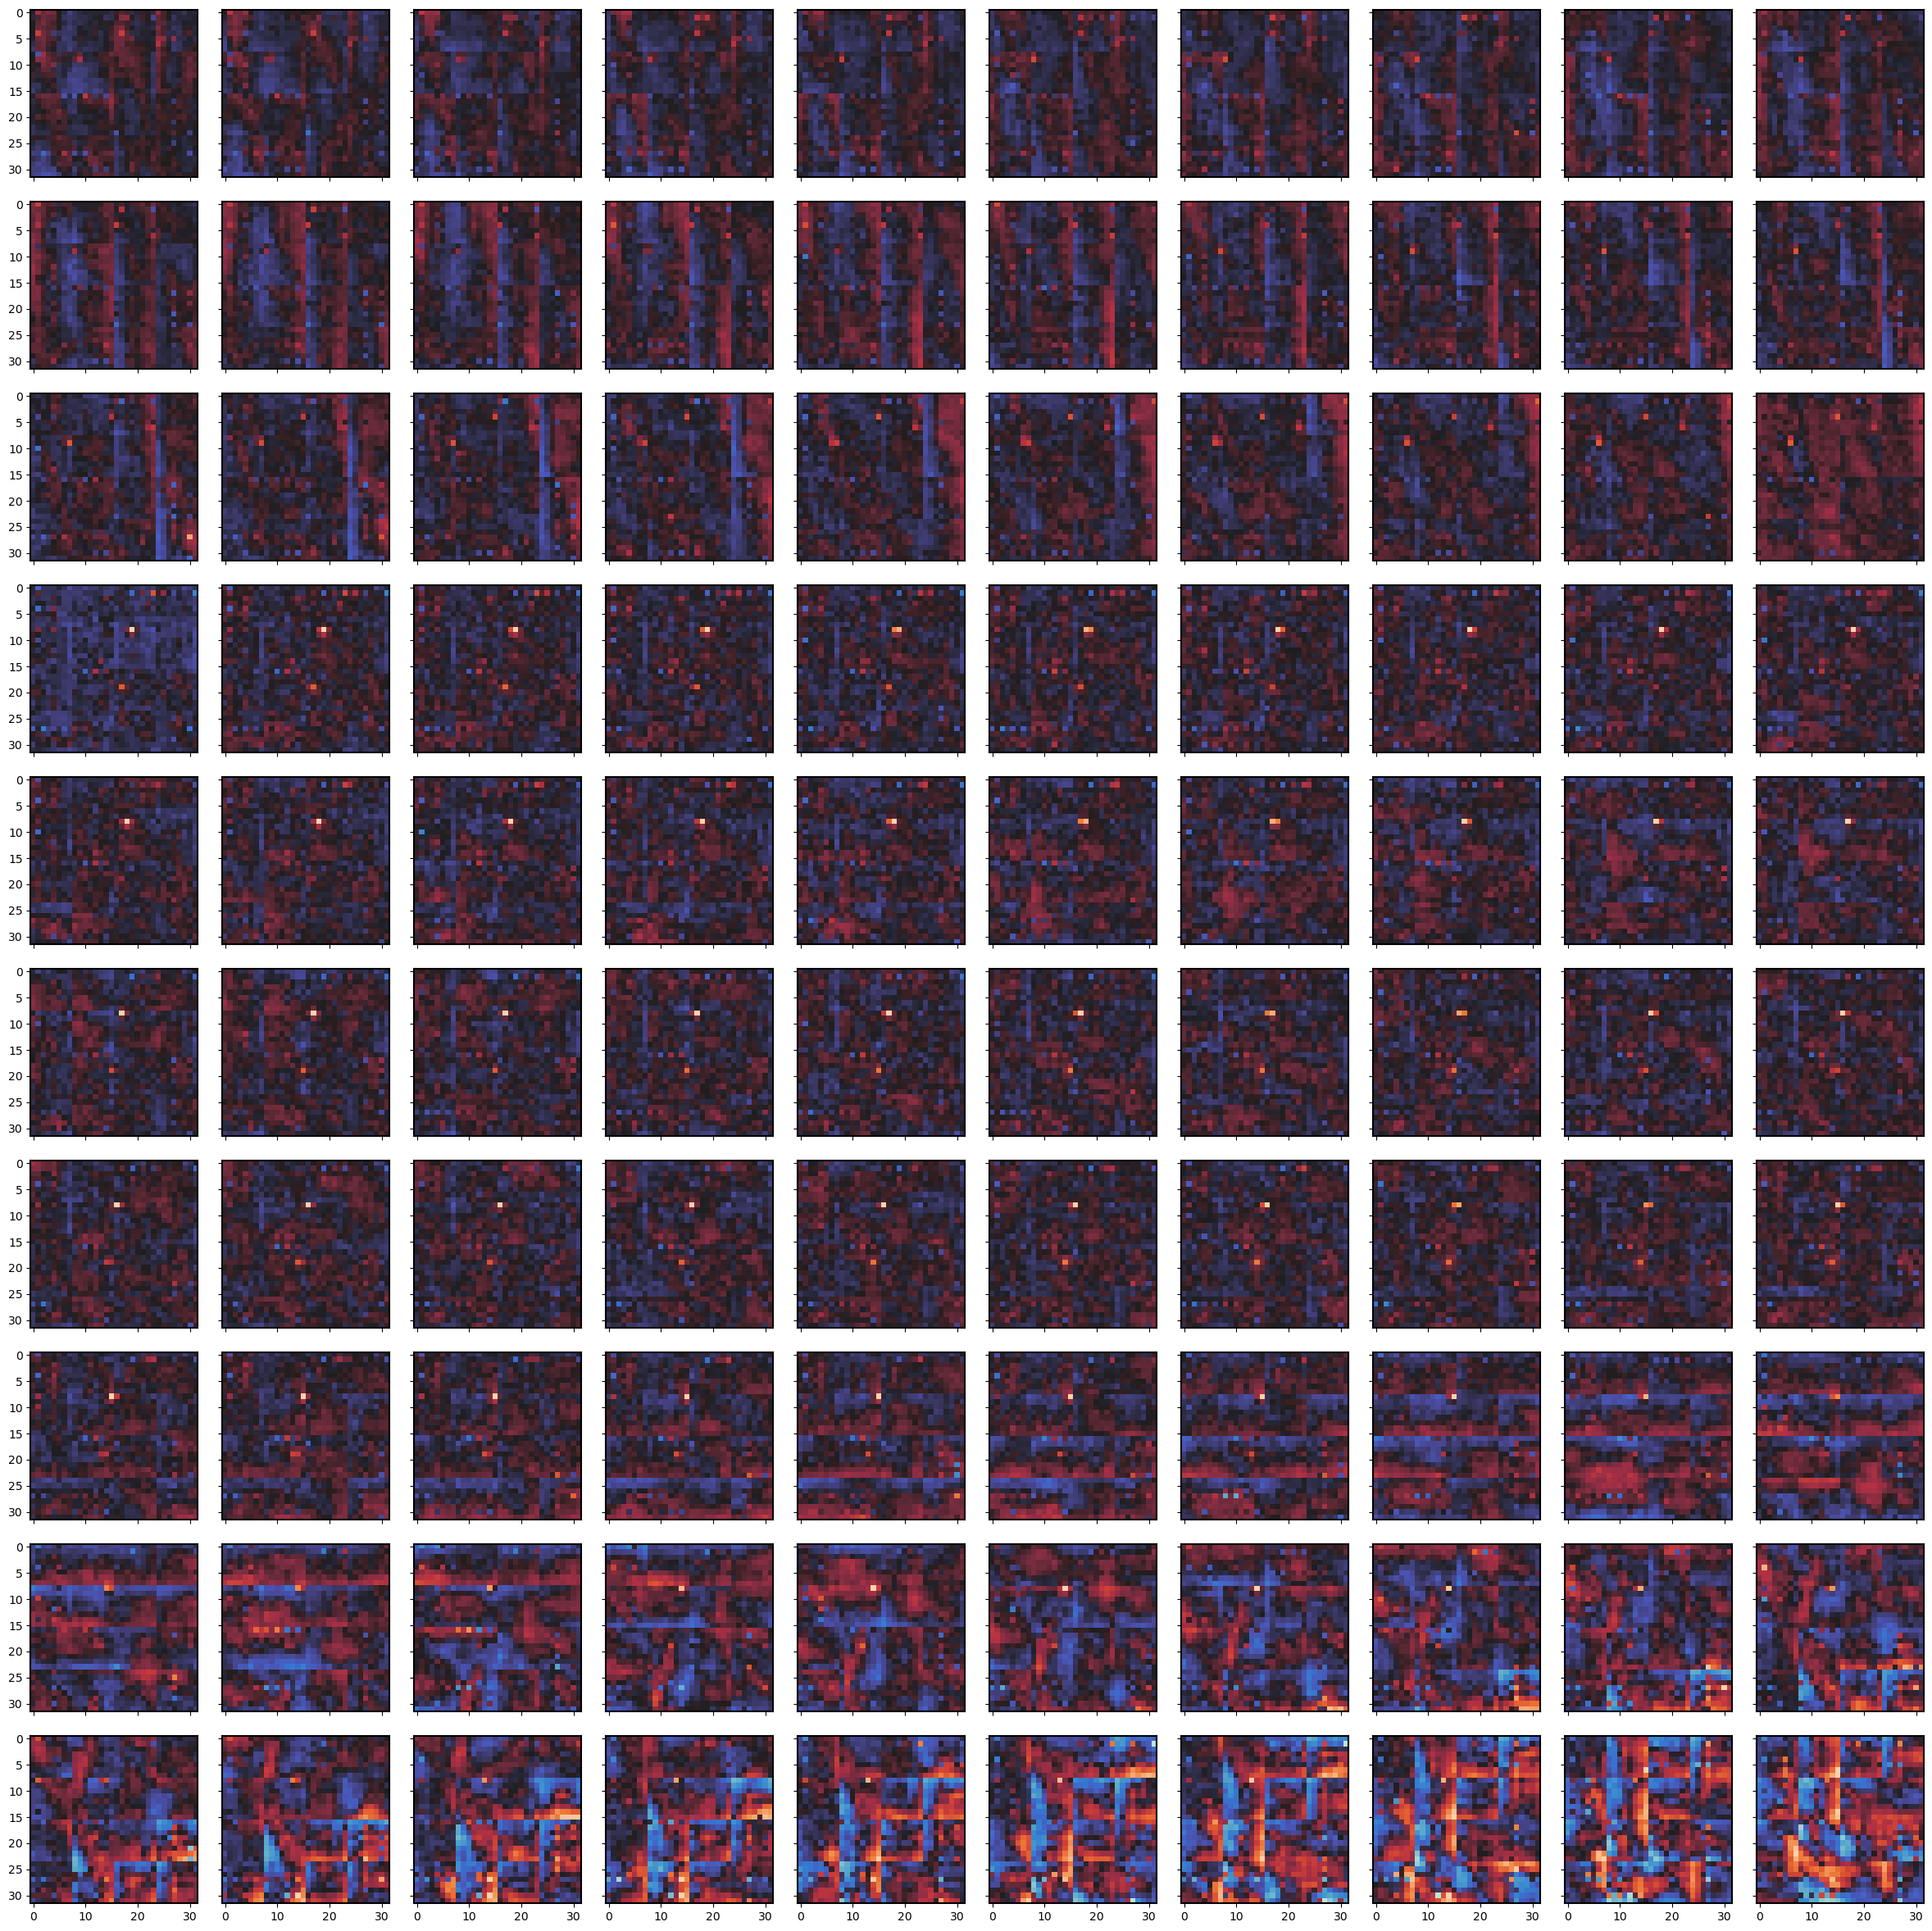

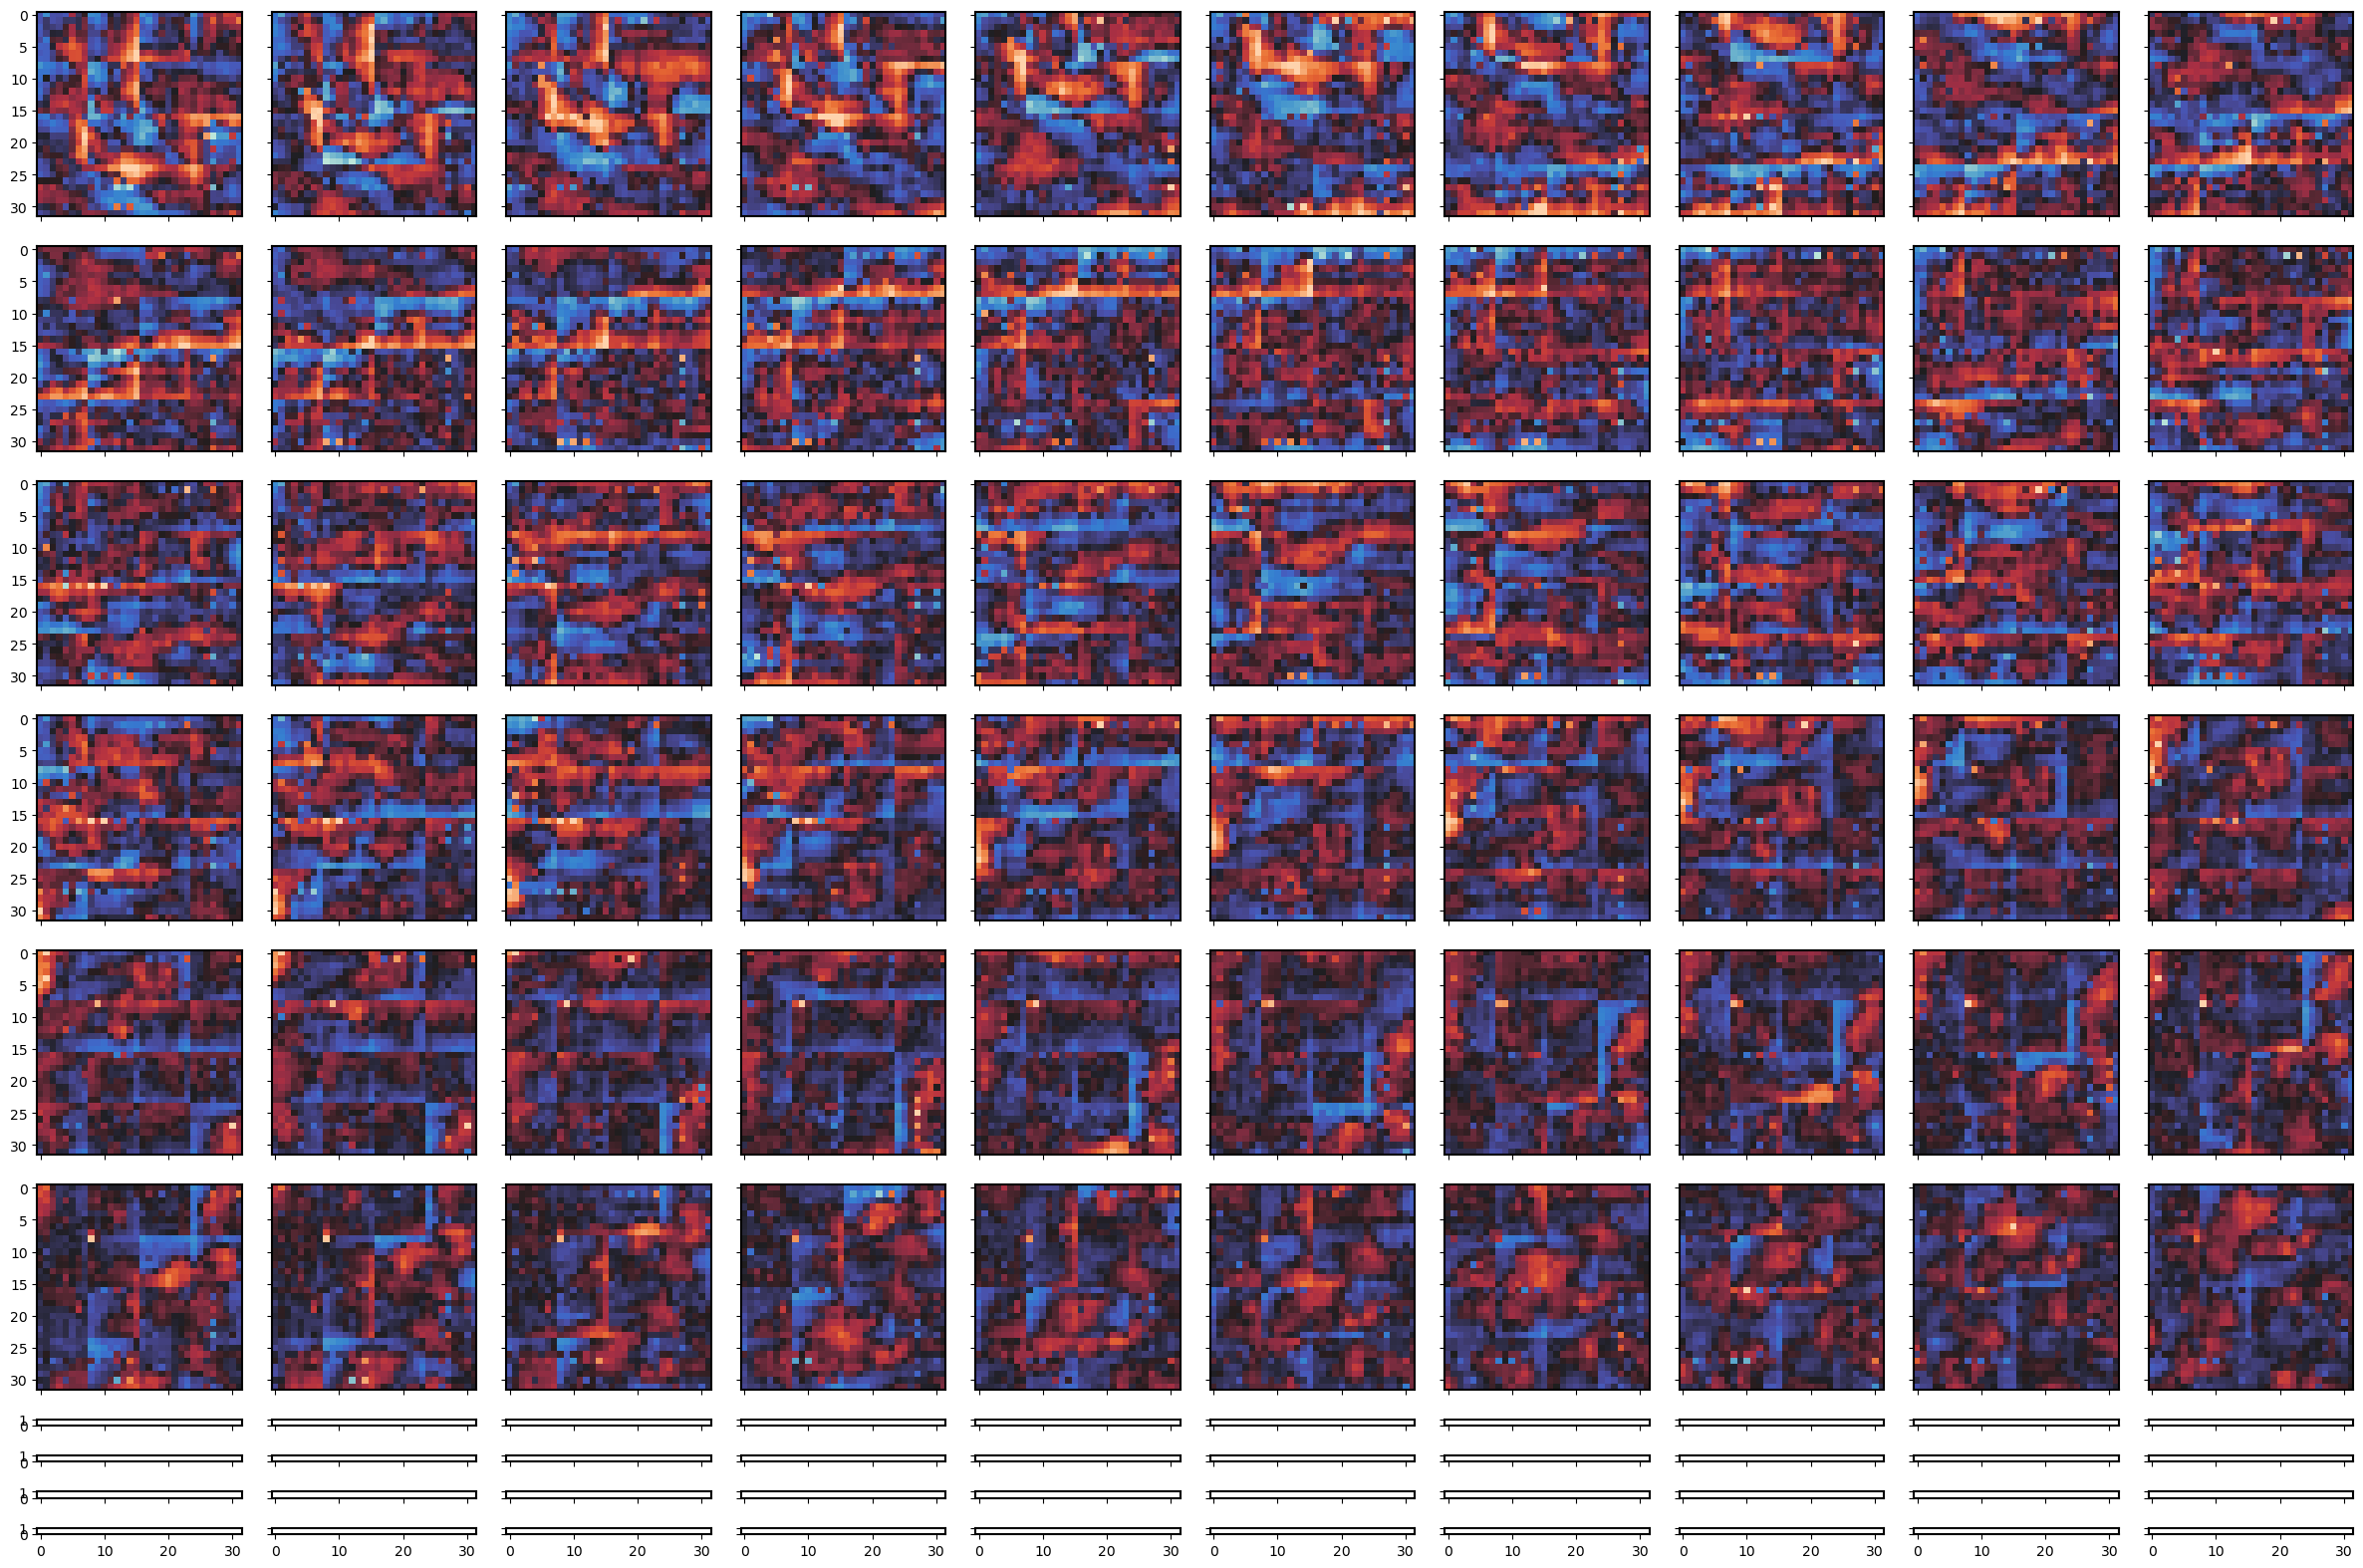

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Density'>

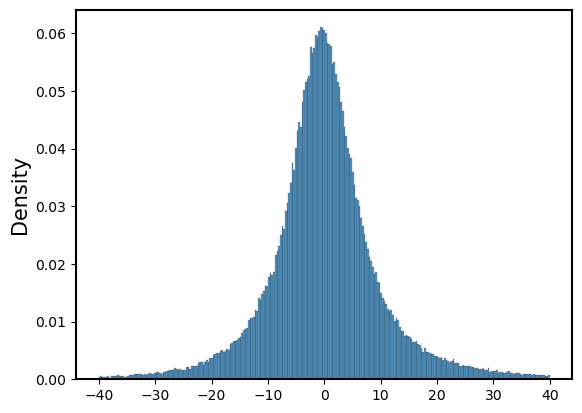

In [196]:
# Test baseline subtraction datastructure
tmin = min(spdf['window_left_unix_t'])
tmax = max(spdf['window_right_unix_t'])
test_times = []

ntimes = 1000

for dt in np.linspace(0, float(tmax - tmin), ntimes):
    test_times.append(tmin + Decimal(str(dt)))

module_id = 254
flat_imgs = []
for t in test_times:
    pano_frame_seek_info = ori.module_file_time_seek(module_id, float(t))
    if pano_frame_seek_info is None:
        # print('Failed to find matching panoseti frames. Skipping...')
        continue
    stacked_img, stacked_meta = ori.stack_frames(
        pano_frame_seek_info['file_idx'],
        pano_frame_seek_info['frame_offset'],
        module_id,
    )
    flat_imgs.append(stacked_img)

# Plot baseline-subtracted images.
plot_grid(flat_imgs, 'auto-flattened-imgs', vmin=-10, vmax=10, cmap='icefire')
plt.show()

# print(f'Min diff = {min(diffs)}, Max diff = {max(diffs)}')
sns.histplot(
    np.array(flat_imgs).ravel(),
    stat='density',
    label='orig - (spatial medians) - supermedian',
    binrange=[-40, 40]
)

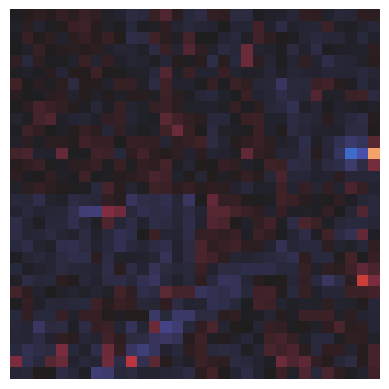

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_88556/2438112594.py:2: RuntimeWarning:

divide by zero encountered in divide



False

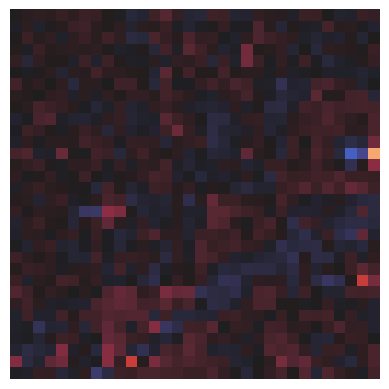

In [28]:
idx = 10
img = buffer[idx] - spdf['spatial_median_img'].iloc[idx]

plot_img(img, vmin=-10, vmax=10, cmap='icefire')
plt.show()
plot_img(flat[idx], vmin=-10, vmax=10, cmap='icefire')
np.allclose(img - flat[idx], np.zeros((32,32)))

In [152]:
# Read data from a csv
div = 1 / np.sqrt(abs(img))
div = np.nan_to_num(div, nan=1)
z  = img

fig = go.Figure(data=[go.Surface(z=z, cmin=-10, cmax=10)])
fig.update_layout(title='Baseline subtracted image', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [28]:
x = np.zeros((5, 32, 32))
len(x)

5

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_27162/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


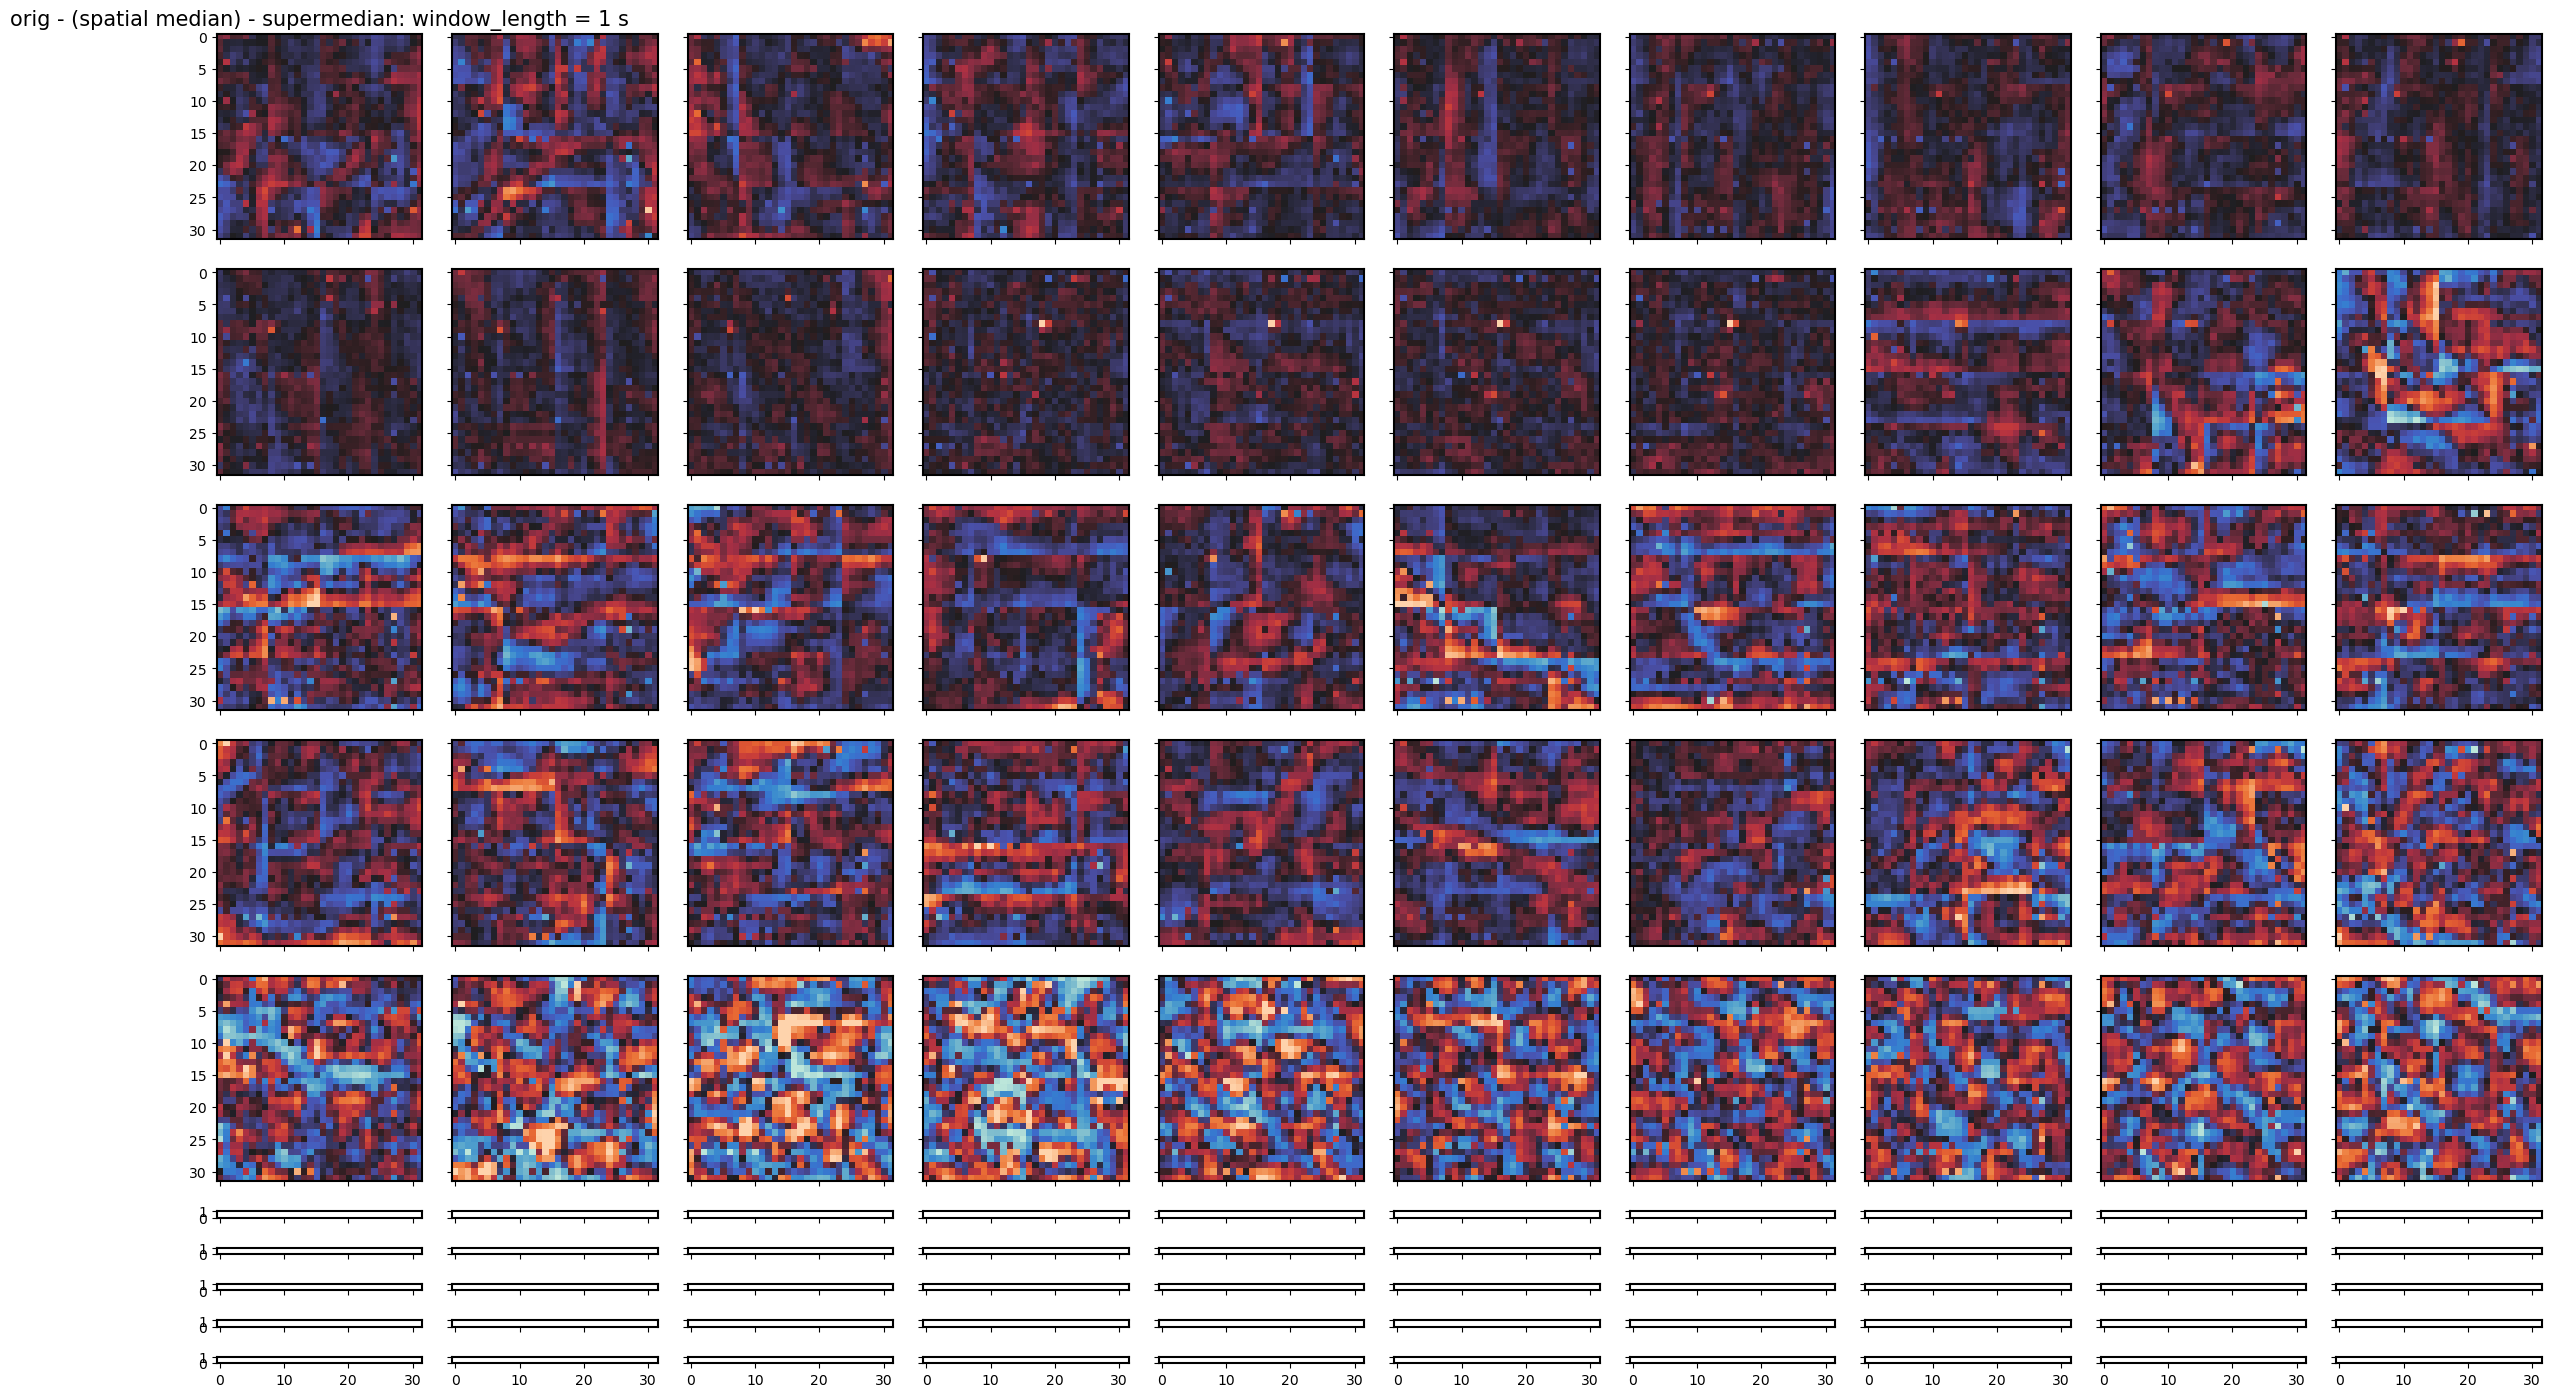

In [255]:
# nstack = 1
# flat_stacked = np.sum(
#     (buffer - supermedian * 2).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:])),
#     axis=0
# )
flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

In [256]:
(nstack * ori.intgrn_usec / 1e6) * 60000

6.0

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_27162/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


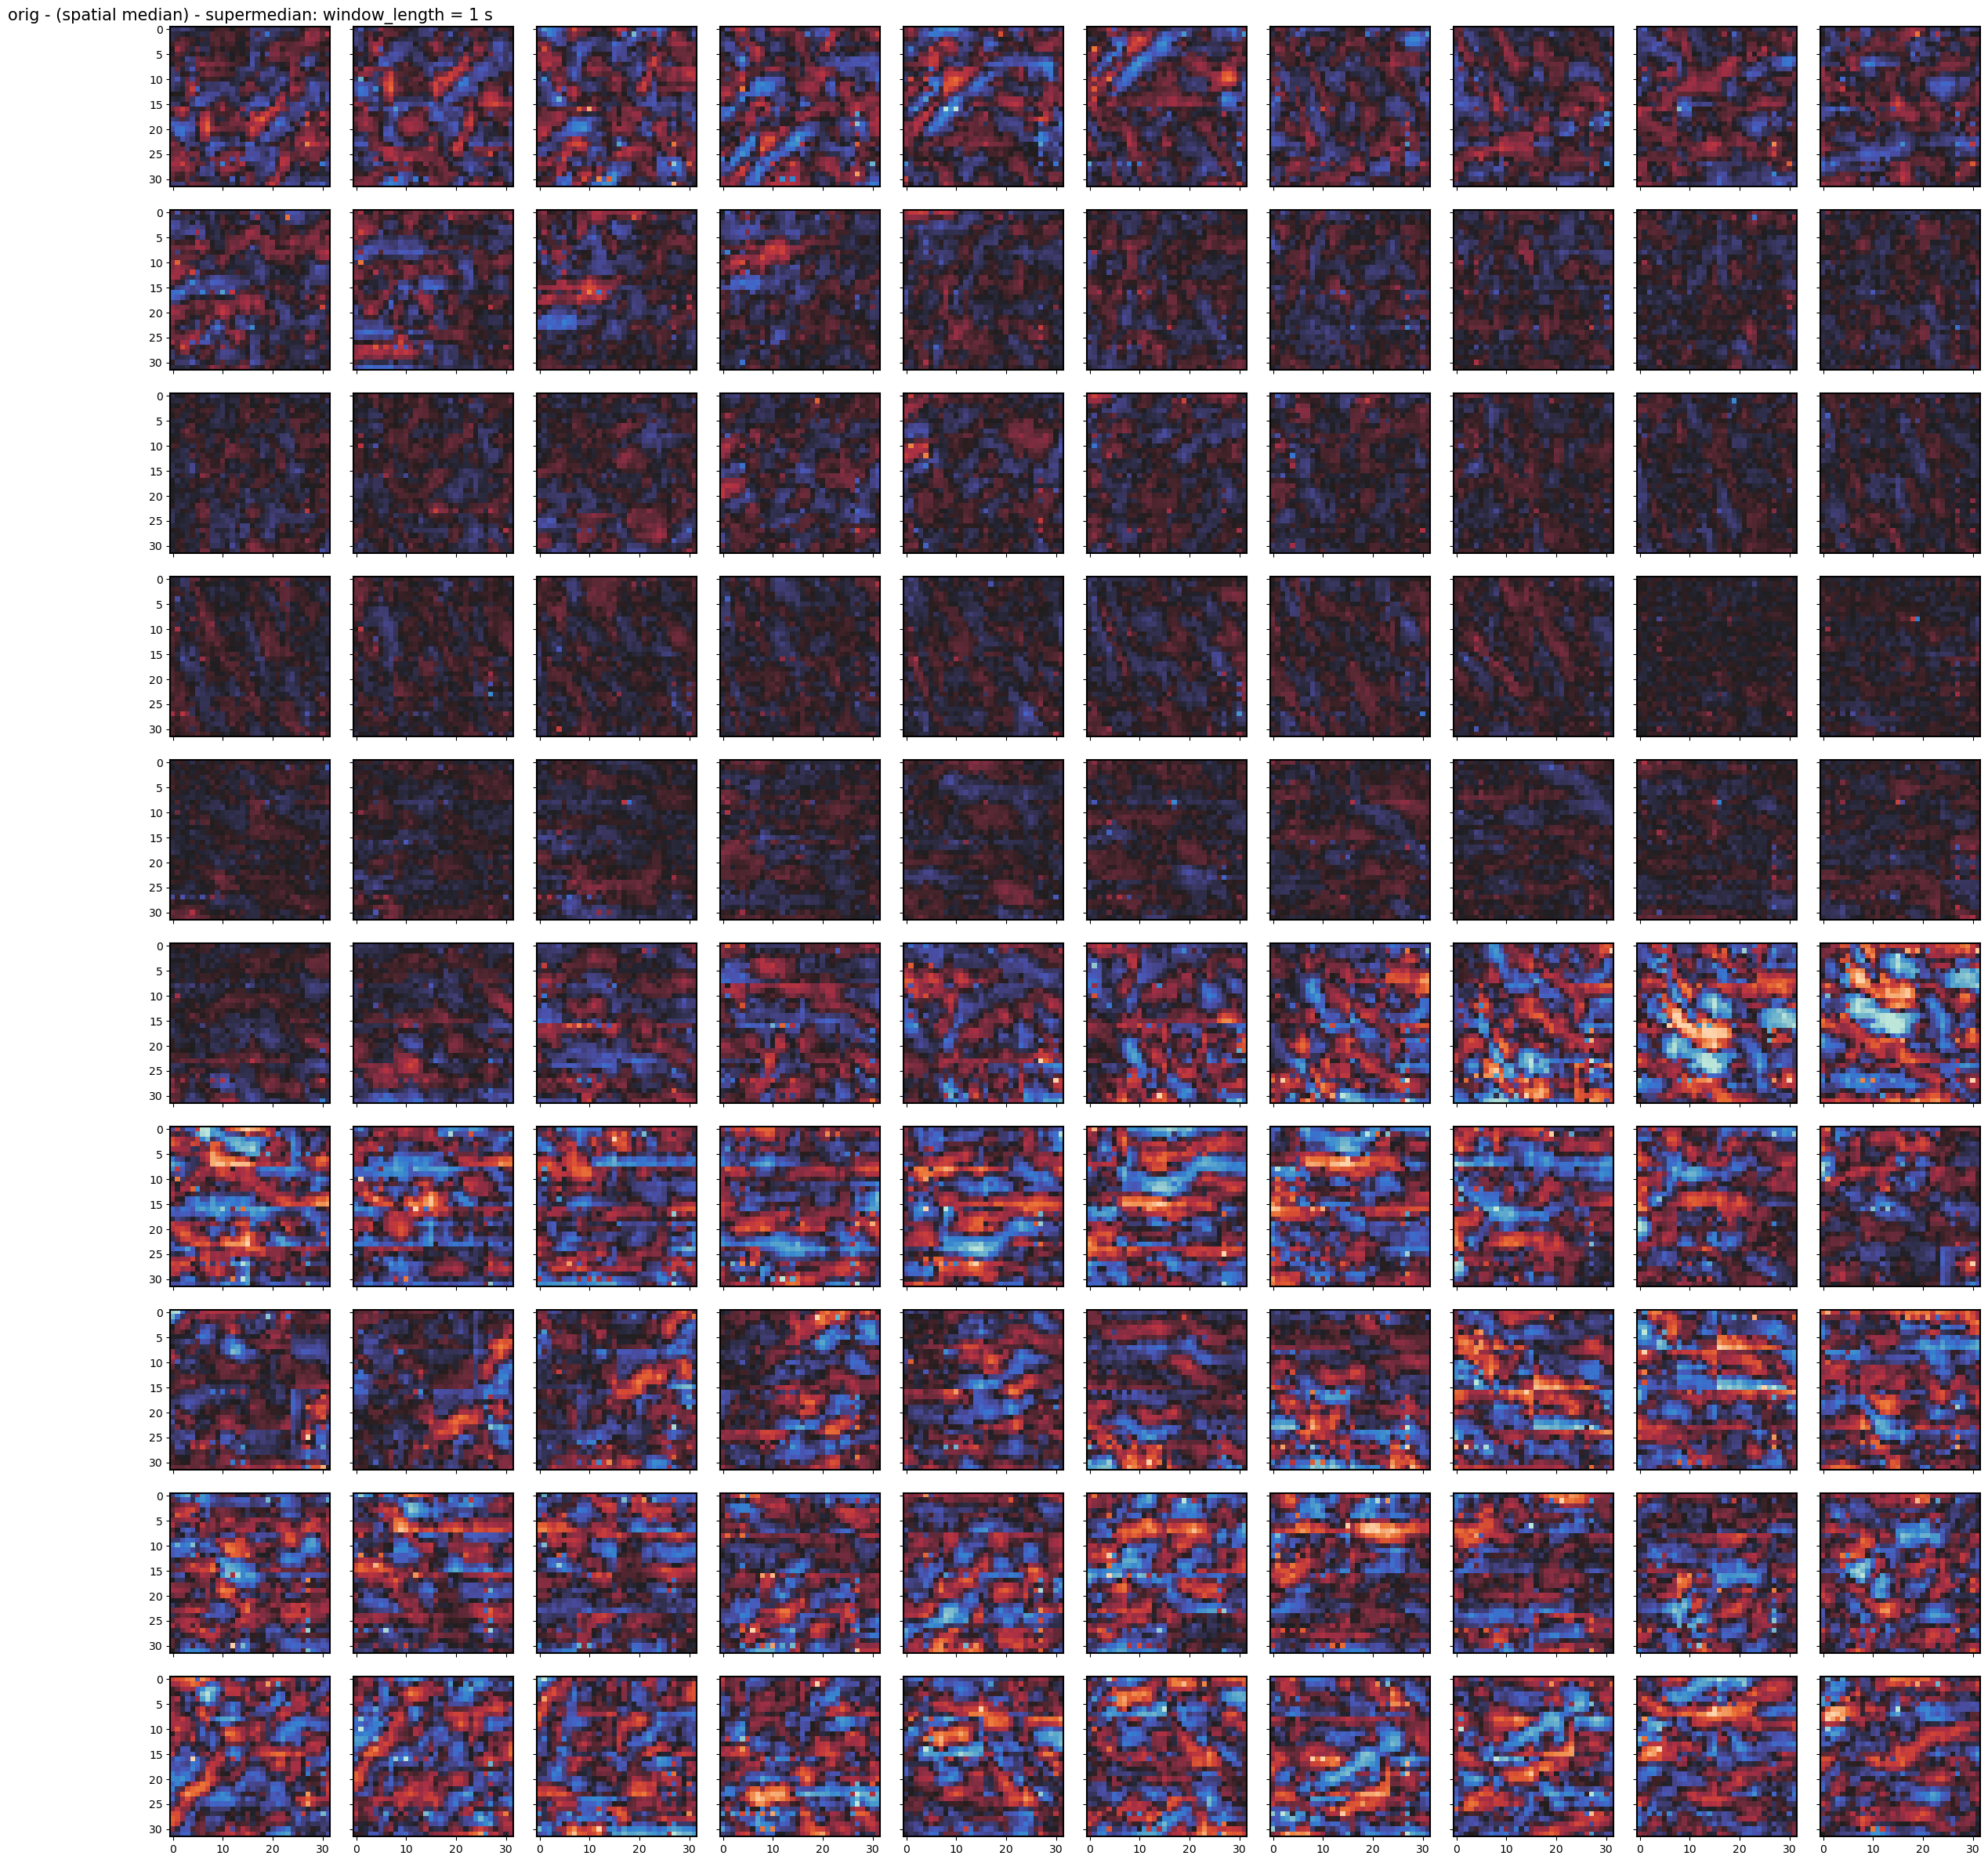

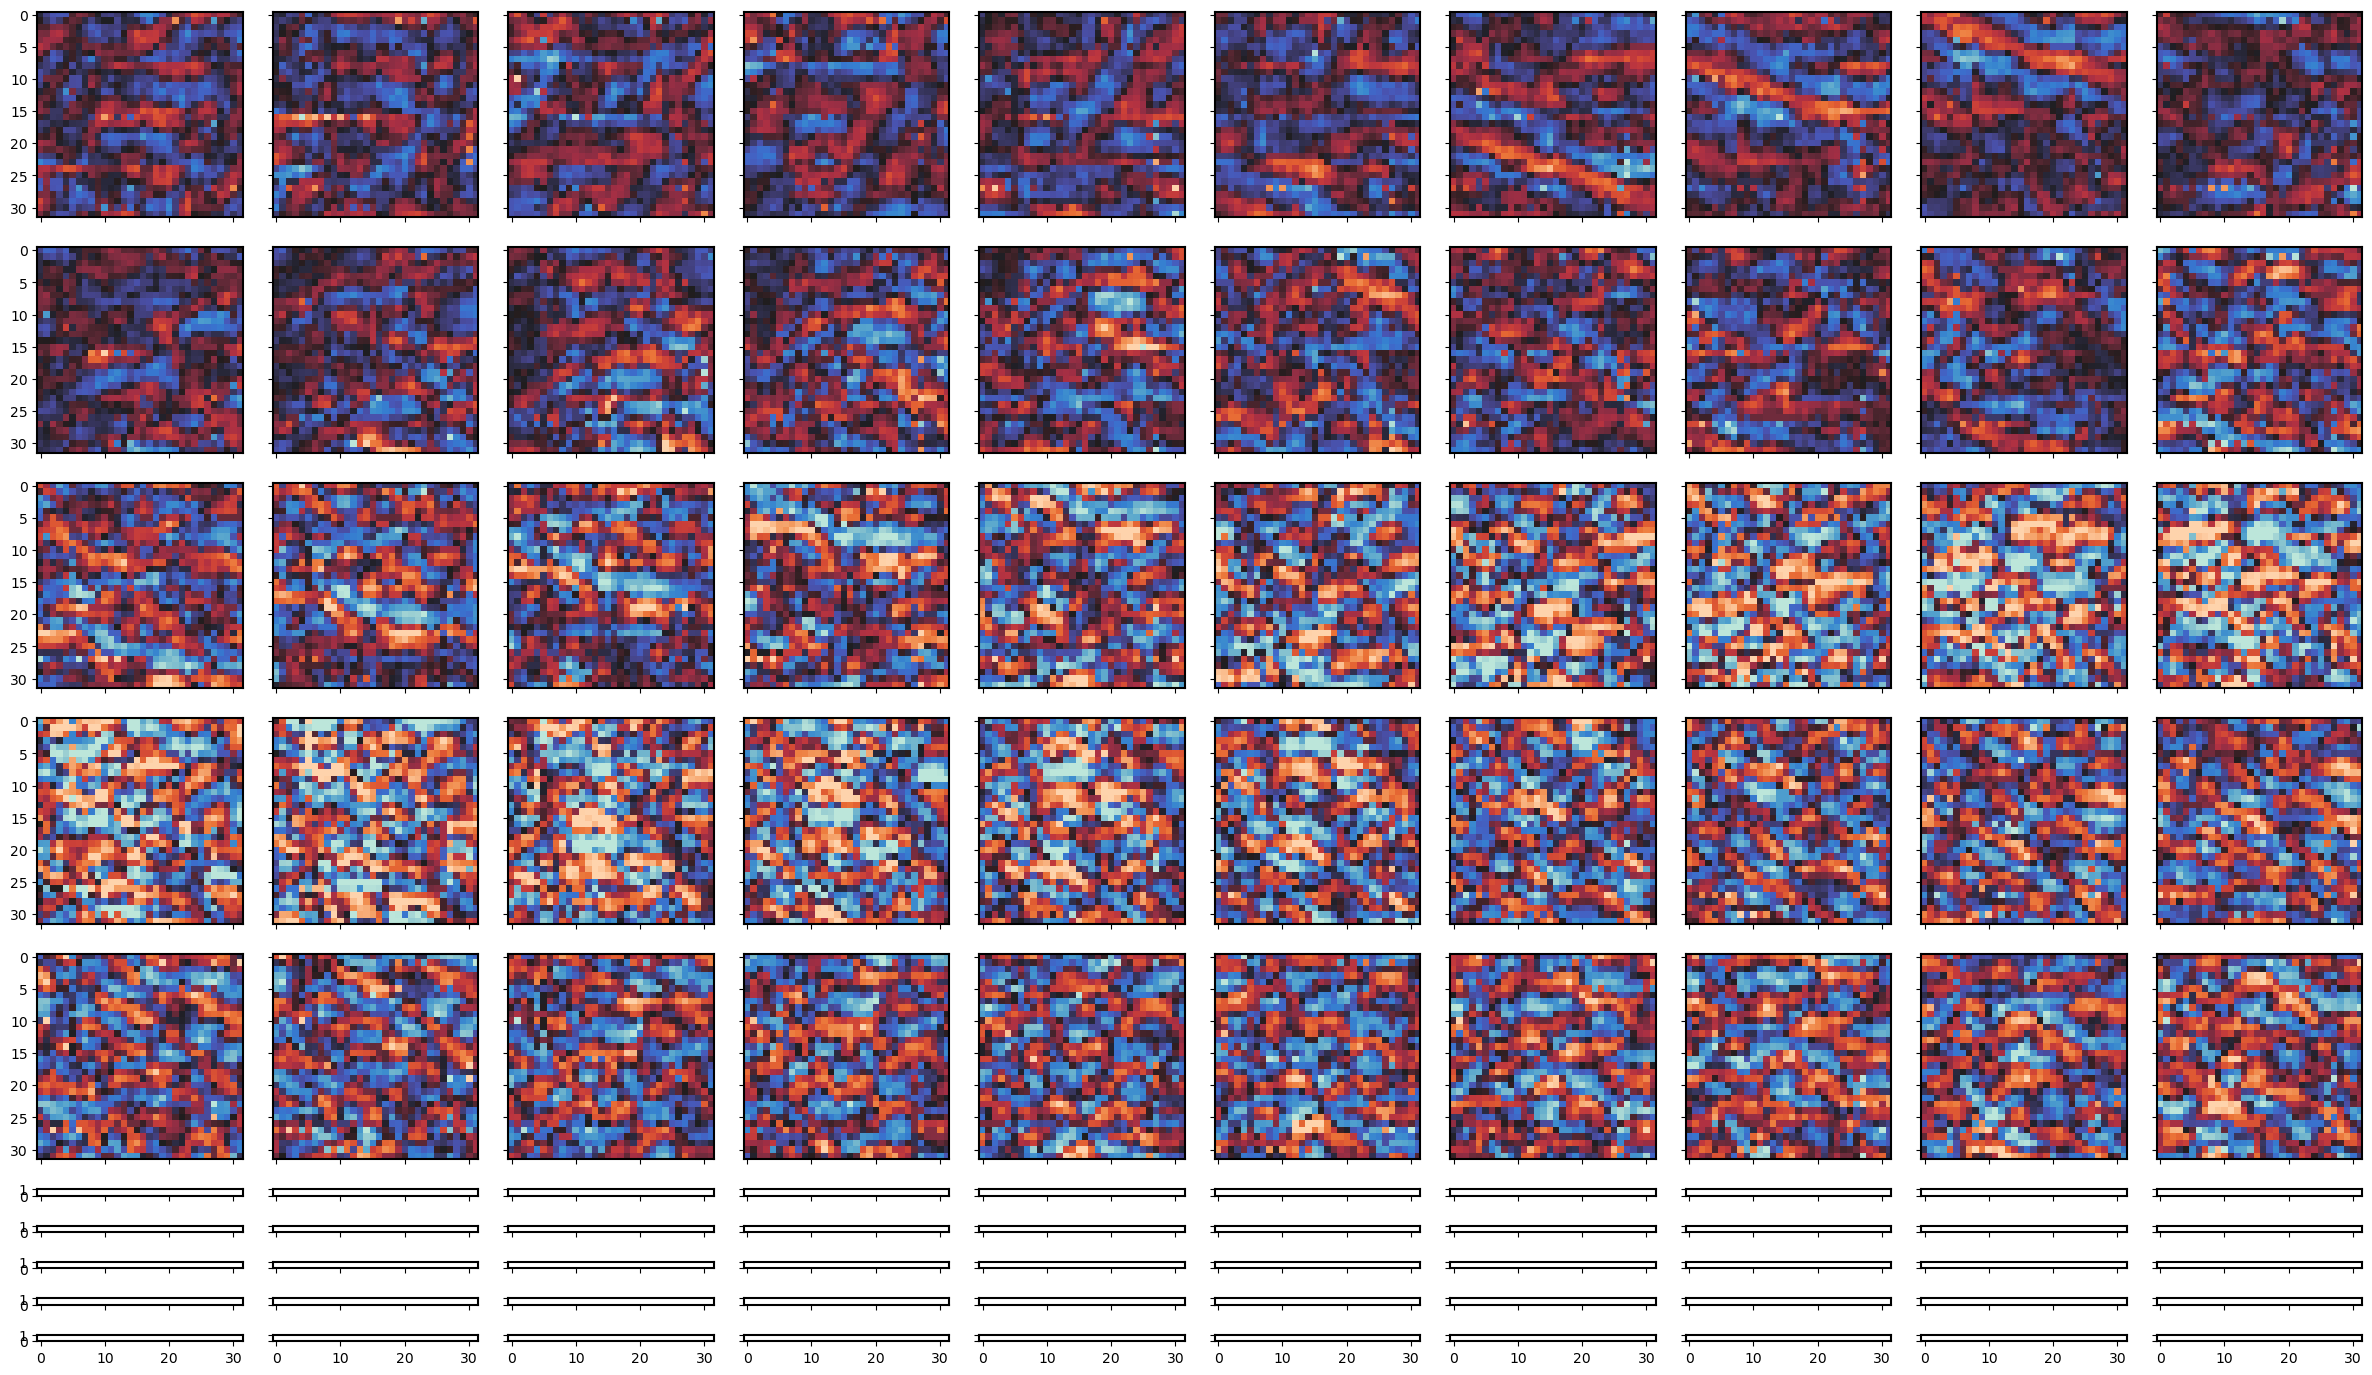

In [257]:
nstack = 1
flat_stacked = flat.reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::100], axis=0) 
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 150)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

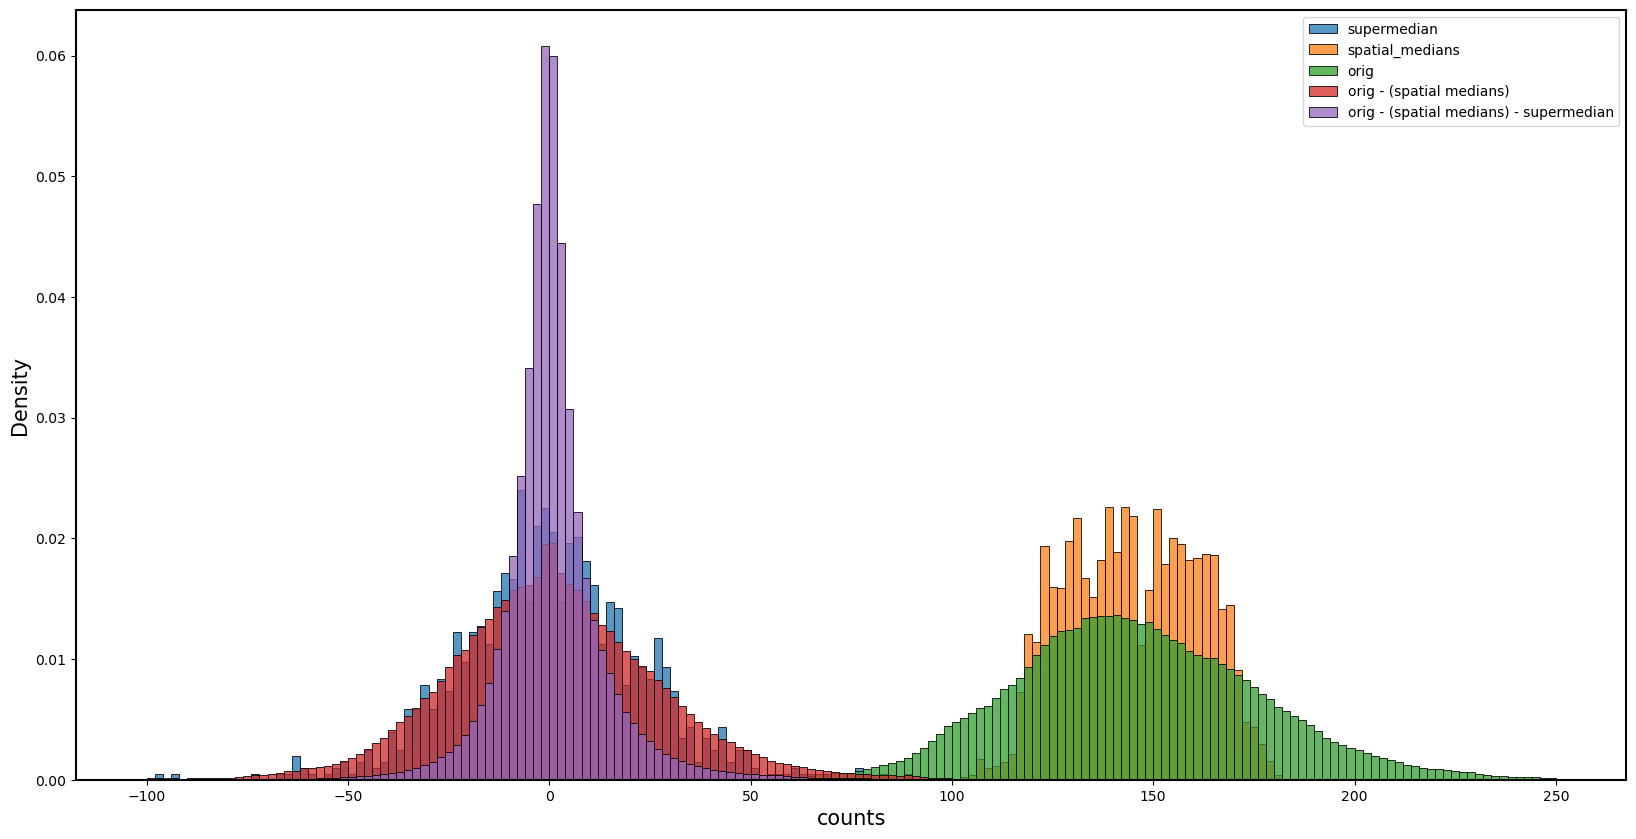

In [253]:
plt.figure(figsize=(20,10))
binrange = [-100, 250]
bins = 175

sm_idxs = np.linspace(0, len(spatial_medians) - 1, 500).astype(int)
bf_idxs = np.linspace(0, len(buffer) - 1, 500).astype(int)
bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 500).astype(int)
flat_idxs = np.linspace(0, len(flat) - 1, 500).astype(int)

sns.histplot(
    supermedian.ravel(), 
    stat='density', 
    label='supermedian', 
    binrange=binrange,
    bins=bins
)
sns.histplot(
    spatial_medians[sm_idxs, :, :].ravel(),
    stat='density',
    label='spatial_medians',
    binrange=binrange,
    bins=bins)
sns.histplot(
    buffer[bf_idxs, :, :].ravel(),
    stat='density',
    label='orig',
    binrange=binrange,
    bins=bins
)
sns.histplot(
    buffer_no_spatial_medians[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians)',
    binrange=binrange, bins=bins
)
sns.histplot(
    flat[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians) - supermedian',
    binrange=binrange,
    bins=bins
)

# sns.histplot(
#     flat_diffs[flat_diff_idxs, :, :].ravel(),
#     stat='density',
#     label='flat diffs',
#     binrange=binrange,
#     bins=bins
# )

# plt.xlim(-100, 100)
plt.xlabel('counts')
plt.legend()